In [1]:
import os
from os import path as ospath
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from spiketools.plts.spikes import plot_firing_rates
from convnwb.io import open_h5file, get_files, load_config, save_json, load_json,make_session_name,load_nwbfile
from convnwb.paths import Paths

from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.data import plot_bar, plot_hist, plot_text, plot_barh
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.utils import compute_pos_ranges, compute_bin_width
from spiketools.utils.trials import recombine_trial_data
from spiketools.utils.epoch import epoch_data_by_range
from spiketools.plts.spatial import plot_position_by_time,plot_heatmap,create_heatmap_title
from spiketools.utils.timestamps import convert_sec_to_min, sum_time_ranges
from spiketools.spatial.occupancy import compute_occupancy,compute_trial_occupancy, compute_bin_edges,compute_bin_counts_pos, normalize_bin_counts
from spiketools.utils.extract import get_range, get_values_by_time_range, get_values_by_times,get_inds_by_times
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.stats.shuffle import shuffle_circular,shuffle_bins
from spiketools.plts.spatial import plot_positions, plot_heatmap
from spiketools.spatial.speed import compute_speed
from spiketools.plts.data import plot_hist, plot_bar, plot_lines
from spiketools.plts.annotate import add_vlines, add_hlines
from spiketools.plts.data import plot_polar_hist
from spiketools.utils.epoch import epoch_spikes_by_range
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.spikes import plot_waveform
from spiketools.stats.shuffle import shuffle_bins,shuffle_isis
from spiketools.plts.trials import plot_rasters
from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values)
from spiketools.plts.style import drop_spines

In [2]:
# Local imports
import sys
sys.path.append('../code')
from plts import plot_task_structure,plot_positions_with_speed
from utils import group_array_by_key
from reports import create_sess_str
from group import get_all_session_paths
from models import create_df_place,fit_anova_place
from trial import get_trial_structure

# Settings 

In [3]:
base_path = "/Users/weijiazhang/Data/Train/nwb"

In [4]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219c',
    'session' : '0'    
}

In [5]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219c_session_0'

# Load Data 

In [6]:
# Load NWB file
nwbfile = load_nwbfile(session, base_path)

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/pynwb/base.py:195: UserWarning: Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.
  warn('Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.')


In [7]:
# Get unit data
n_units = len(nwbfile.units)
print('Number of unit: {}'.format(n_units))
session['n_units'] = n_units

Number of unit: 23


In [8]:
# Get spiking activity from across all units
all_spikes = [nwbfile.units.get_unit_spike_times(uind) for uind in range(n_units)]

In [9]:
# Calculate the average overall firing rate of each neuron
rates = [compute_firing_rate(spikes) for spikes in all_spikes]

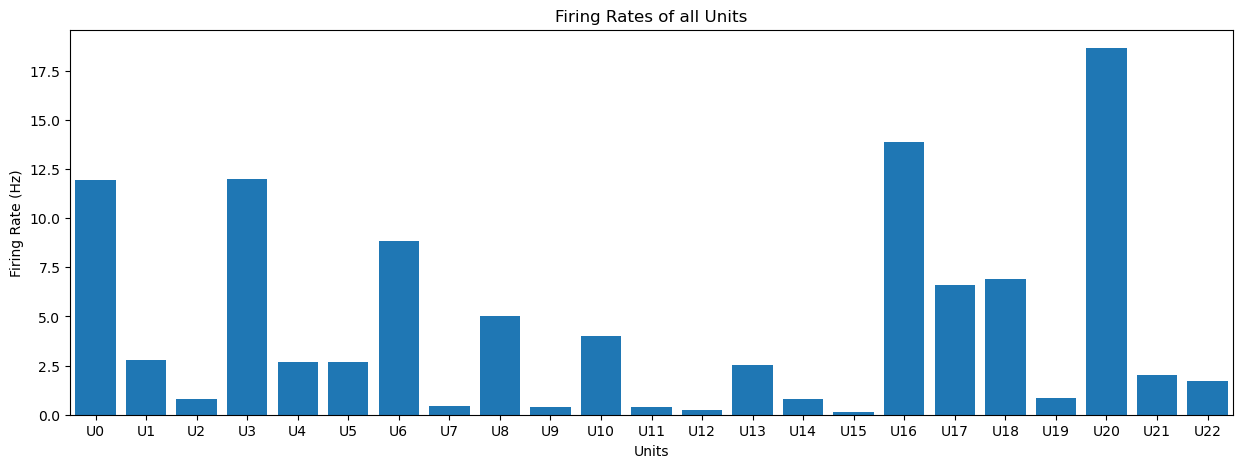

In [10]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

## Get position data 

In [11]:
# Grab the position data
pos = nwbfile.acquisition['position']['player_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

In [12]:
print("ptimes:", ptimes.shape)
print("positions:", positions.shape)

ptimes: (7654,)
positions: (7654,)


In [13]:
# Compute position ranges
x_min_track, x_max_track = compute_pos_ranges(positions)
track_range = [x_min_track,x_max_track]
track_length = x_max_track-x_min_track

print('Track Range: ', track_range)
print('Track Length: ', track_length)

Track Range:  [-33.9997, 34.851]
Track Length:  68.85069999999999


In [14]:
# Binning 
num_bins =40
bins = np.linspace(x_min_track, x_max_track, num_bins+1)
bin_edges = compute_bin_edges(positions, num_bins)
bin_width = compute_bin_width(bin_edges)
print('Number of bins: ', num_bins)
print('Bin widths: {:1.2f}'.format(bin_width))

Number of bins:  40
Bin widths: 1.72


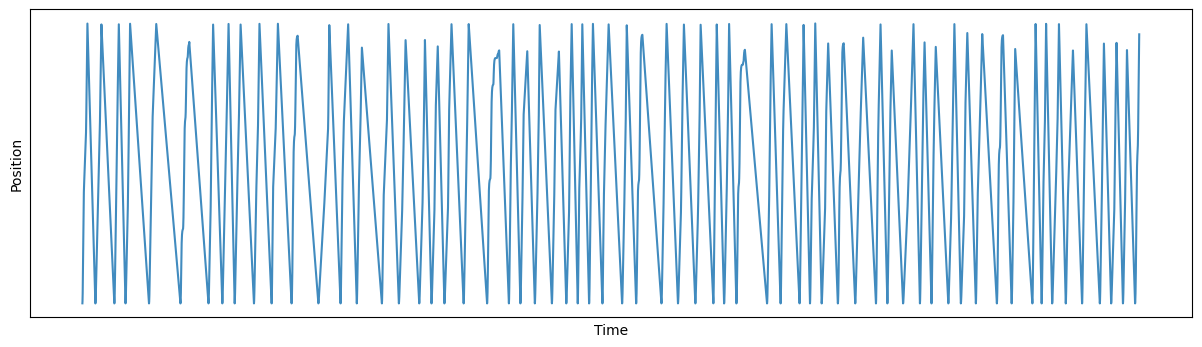

In [16]:
# Plot position across time
plot_position_by_time(ptimes, positions, alpha=0.85, figsize=(15, 4))

## Get speed data 

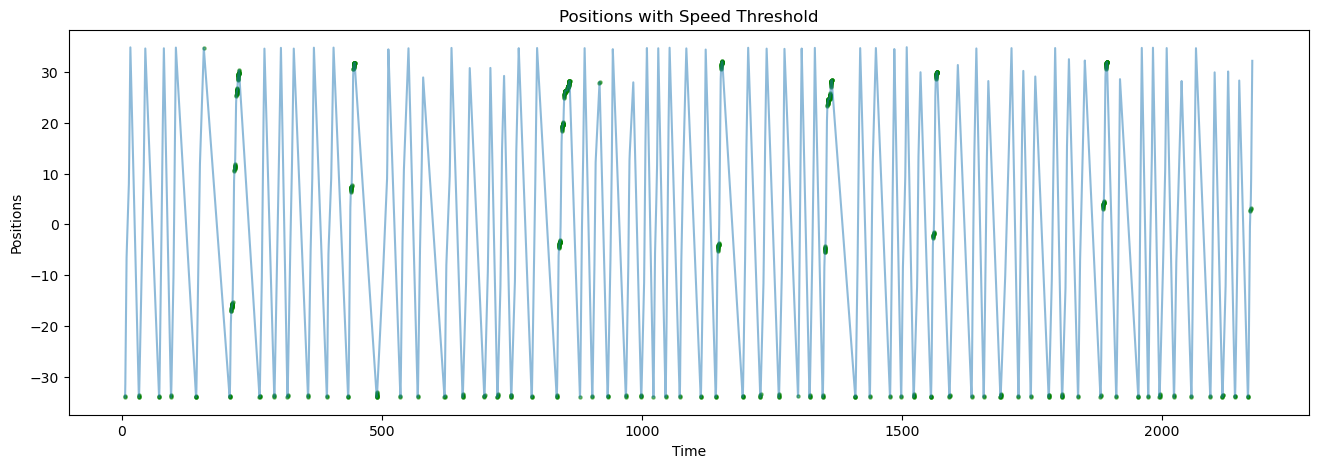

In [17]:
speed_thresh =2
speed = compute_speed(positions, ptimes)
plot_positions_with_speed(ptimes, positions, speed,speed_thresh)

## Get trial structure 

In [18]:
move_start = nwbfile.trials['movement_start_time']
move_end = nwbfile.trials['movement_stop_time']

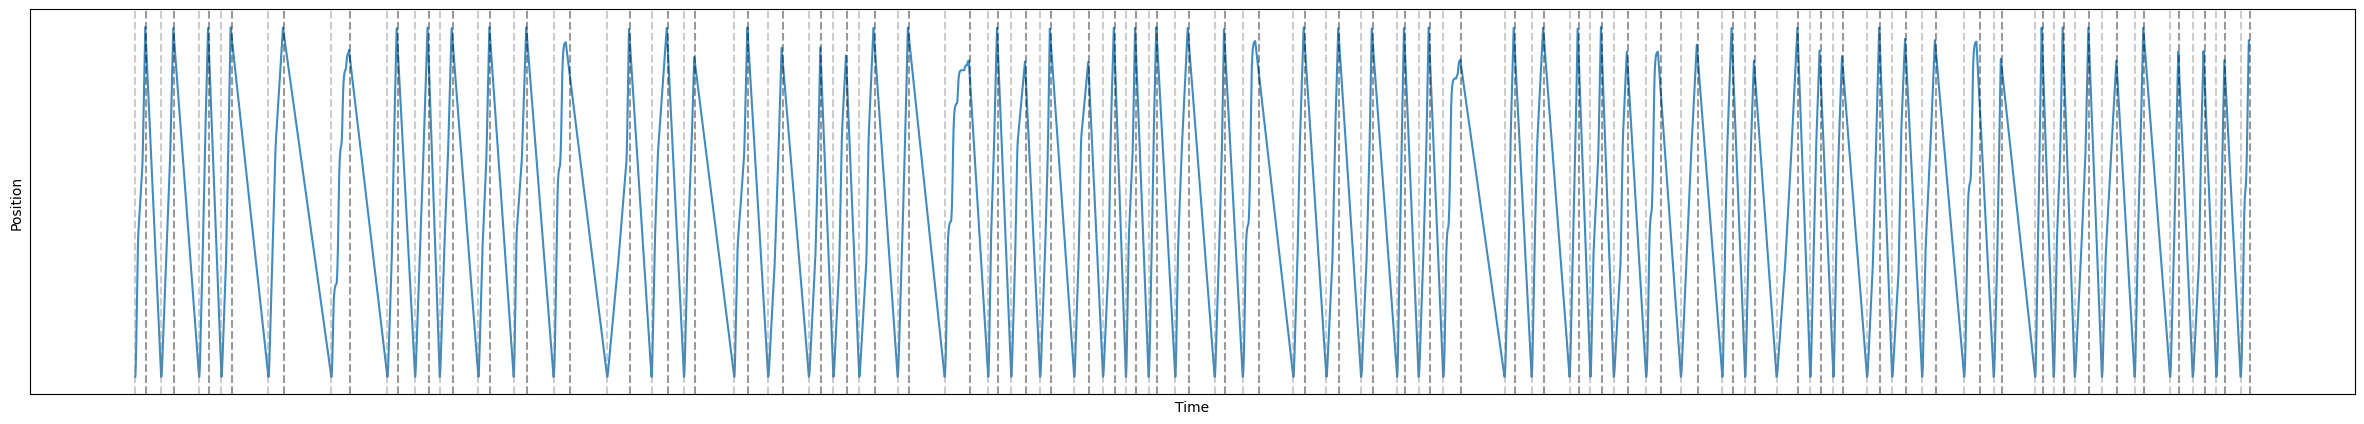

In [19]:
plot_position_by_time(ptimes, positions, alpha=0.85,figsize=(30, 5))
for start in move_start:
    plt.axvline(x=start, color='grey', alpha=0.4, linestyle='--', label='Trial Start' if start == move_start[0] else "")
for end in move_end:
    plt.axvline(x=end, color='black', alpha=0.4, linestyle='--', label='Trial End' if end == move_end[0] else "")

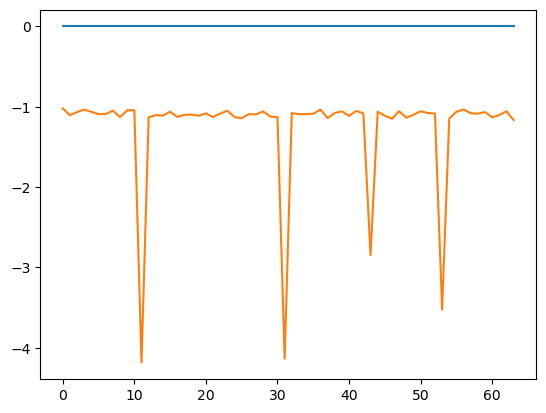

In [20]:
## trial structure check
trial_start,trial_end = get_trial_structure(ptimes, positions,mini=-25,maxi = 25, dist = 100)
# Plot the difference between movement start and trial start 
min_trials_len = np.min([len(move_start),len(trial_start)])
plt.plot(trial_start[:min_trials_len]-move_start[:min_trials_len])
plt.plot(trial_end[:min_trials_len]-move_end[:min_trials_len])

# Occupancy With Spatial mask 

Track range: [-30.559699999999996, 27.971]
Number of bins: 34


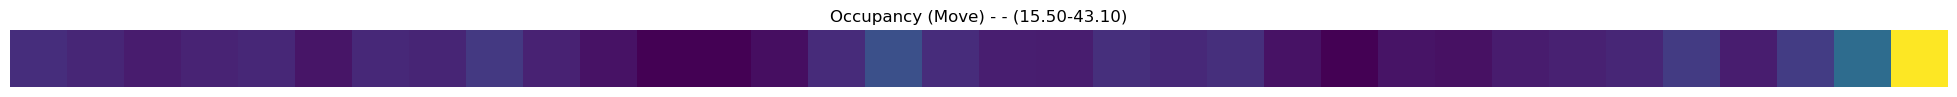

In [61]:
stoping_zone = 4
starting_zone= 2

x_min = x_min_track+starting_zone*1.72
x_max = x_max_track-stoping_zone*1.72

track_range = [x_min,x_max]
print('Track range:', track_range)


move_bins = num_bins-stoping_zone-starting_zone
print('Number of bins:' , move_bins)
move_occ = compute_occupancy(positions, ptimes, move_bins,min_speed=speed_thresh,area_range = track_range)
plot_heatmap(move_occ, title=create_heatmap_title('Occupancy (Move) -',move_occ), figsize=(25, 5))

# Single unit 

In [62]:
# Extract spikes for a unit of interest
uind = 1
spikes = nwbfile.units.get_unit_spike_times(uind)
print(spikes.shape)

(6571,)


Text(0.5, 1.0, 'Unit 1')

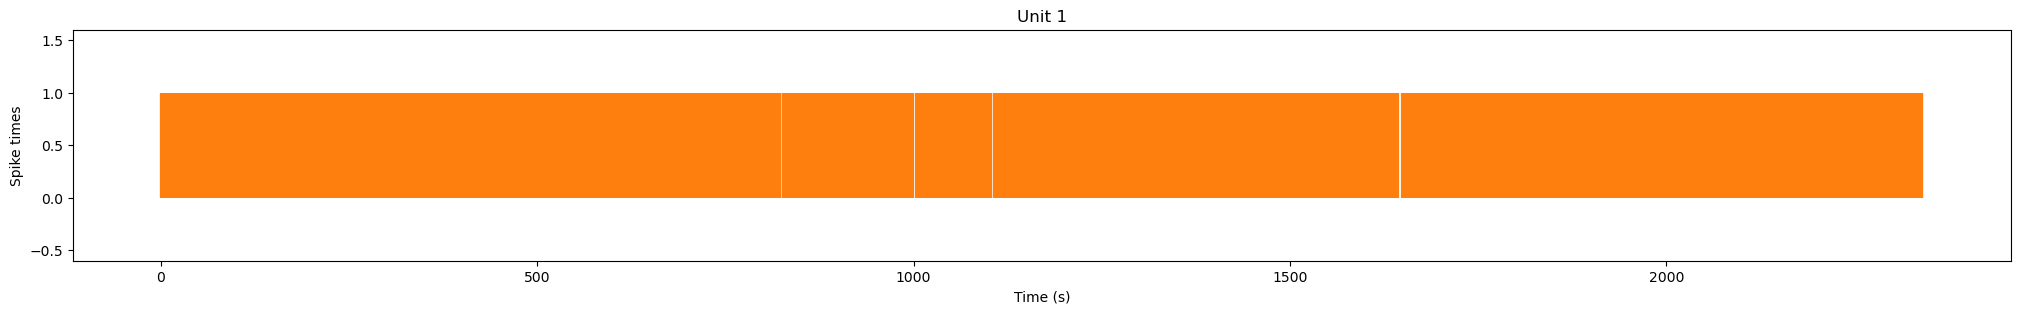

In [63]:
plt.figure(figsize=(25, 3))
plt.eventplot(spikes, lineoffsets=0.5, colors=f'C{uind}')
plt.xlabel('Time (s)')
plt.ylabel('Spike times')
plt.title(f'Unit {uind}')

In [64]:
# Get spikes during movement period 
spikes_move = epoch_spikes_by_range(spikes, move_start, move_end, reset=False)
move_spikes_all = np.concatenate(spikes_move).ravel()

Text(0.5, 1.0, 'Unit 1')

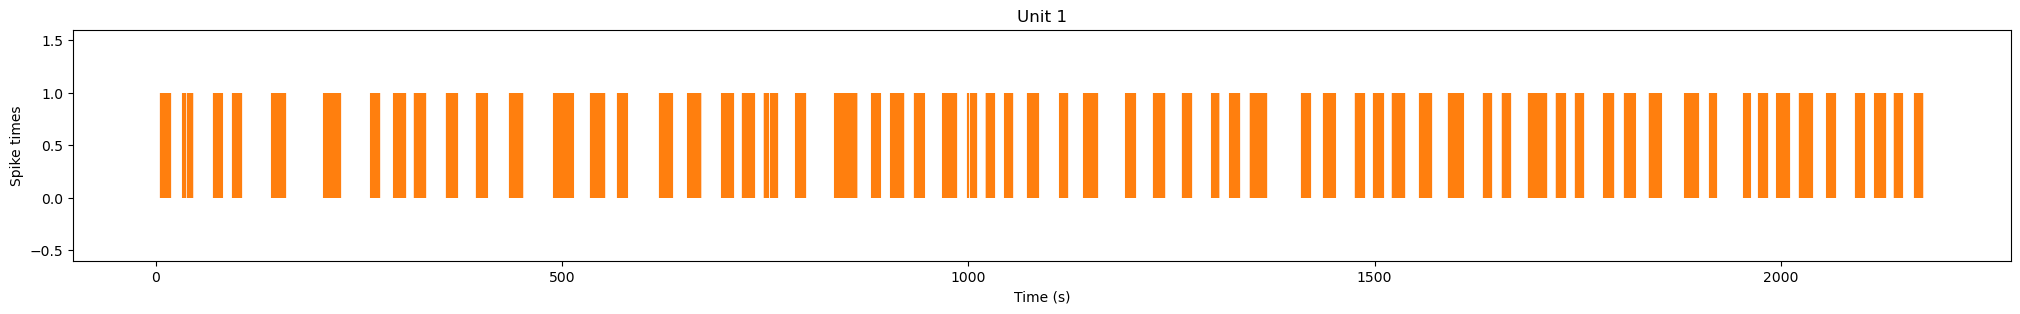

In [65]:
plt.figure(figsize=(25, 3))
plt.eventplot(move_spikes_all, lineoffsets=0.5, colors=f'C{uind}')
plt.xlabel('Time (s)')
plt.ylabel('Spike times')
plt.title(f'Unit {uind}')

## Filter position data based on starting and stopping zone 

In [66]:
# Get spike positions within move zone 
filt_ptimes = ptimes[(positions < x_max) & (positions > x_min)]
filt_positions = positions[(positions < x_max) & (positions > x_min)]

print("Filtered ptimes:", filt_ptimes.shape)
print("Filtered positions:", filt_positions.shape)

Filtered ptimes: (6283,)
Filtered positions: (6283,)


In [99]:
filt_spike_pos = []
spike_t = []
for ind in range(len(spikes_move)): 
    m_spikes = spikes_move[ind]
    filt_spike_pos.append(get_values_by_times(filt_ptimes, filt_positions, m_spikes,time_threshold = .1))
    spike_t.append(get_values_by_times(filt_ptimes,filt_ptimes,m_spikes,time_threshold = .1))
spike_times_all = np.concatenate(spike_t).ravel()
filt_spike_pos_all = np.concatenate(filt_spike_pos).ravel()

## Compute firing rate 
m_bins = np.linspace(x_min, x_max, move_bins+1)
move_sc = compute_bin_counts_pos(filt_spike_pos_all, move_bins)
move_fr = move_sc / move_occ

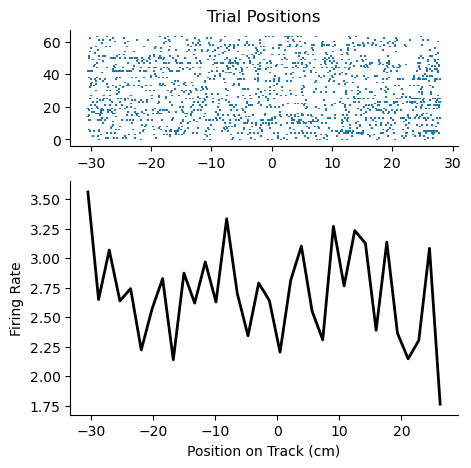

In [100]:
fig, axs = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [1, 2],})
plt.subplots_adjust(hspace=0.2) 
plot_rasters(filt_spike_pos,ax = axs[0], vline=None, figsize=(10, 5), show_axis=True, title='Trial Positions')
axs[0].spines['top'].set_visible(False) 
axs[0].spines['right'].set_visible(False)
# Firing rate map
axs[1].plot( m_bins[:-1],move_fr[:], 'k', lw=2)
axs[1].set_xlabel('Position on Track (cm)')
axs[1].set_ylabel('Firing Rate')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Statistics 

## Spatial Info 

In [101]:
spike_info = compute_spatial_information(move_fr, move_occ)
print(f'Spatial_Info: {np.round(spike_info,3)}')

Spatial_Info: 0.019


## ANOVA 

In [102]:
move_trial_occupancy = compute_trial_occupancy(positions, ptimes, move_bins, move_start, move_end,area_range = track_range)

# Step2: Compute firing rate for each spatial bin for each trial
move_trial_place_bins = compute_trial_place_bins(spikes, positions, ptimes,move_bins, move_start, move_end,time_threshold = .1,
                                            trial_occupancy=move_trial_occupancy, area_range = track_range,flatten=True)

# Step3: Create the data frame
move_df = create_df_place(move_trial_place_bins)


# Step4: Compute ANOVA f-value
move_f_val = fit_anova_place(move_df)
print('F value: ', round(move_f_val,3))

F value:  0.887


/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/spiketools/utils/checks.py:288: UserWarning: The data values extend beyond the given bin definition.
  warnings.warn(msg)


## Shuffle 

In [103]:
n_surrogates = 100
times_shuffle = shuffle_spikes(move_spikes_all, 'circular', n_shuffles=n_surrogates)

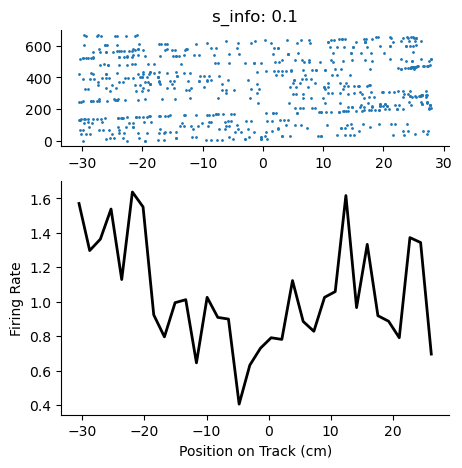

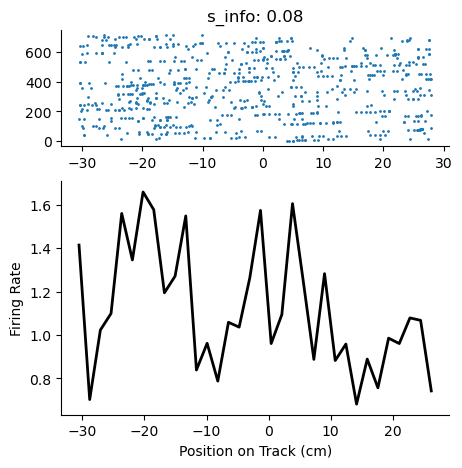

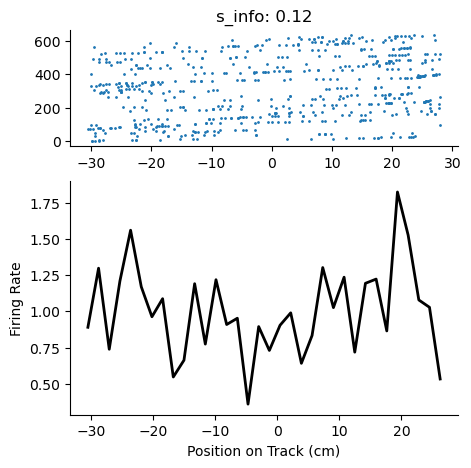

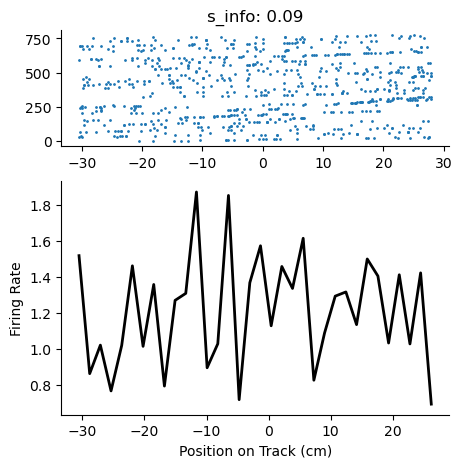

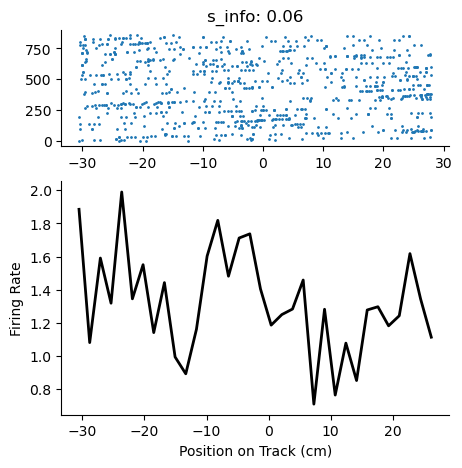

In [104]:
# Shuffles Check 
for ind, stimes in enumerate(times_shuffle[:5]):

    spike_p = get_values_by_times(filt_ptimes, filt_positions, stimes,time_threshold = .1)
    sc = compute_bin_counts_pos(spike_p, move_bins)
    fr = sc/ move_occ   
    s_info = compute_spatial_information(fr, move_occ, normalize=True)
    fig, axs = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [1, 2],})
    plt.subplots_adjust(hspace=0.2)  # Adjust the vertical spacing between subplots

    axs[0].scatter(spike_p, np.arange(len(spike_p)),s=1)
    axs[0].spines['top'].set_visible(False)  # Hide the top spine
    axs[0].spines['right'].set_visible(False)
    axs[0].set_title(f's_info: {np.round(s_info,2)}')
    # Firing rate map
    axs[1].plot( m_bins[:-1],fr, 'k', lw=2)
    axs[1].set_xlabel('Position on Track (cm)')
    axs[1].set_ylabel('Firing Rate')
    axs[1].spines['top'].set_visible(False)  # Hide the top spine
    axs[1].spines['right'].set_visible(False)

### Shuffle Spike Info

In [105]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    
    spike_p = get_values_by_times(filt_ptimes, filt_positions, stimes,time_threshold = .1)

    spike_counts = compute_bin_counts_pos(spike_p, move_bins)
    bin_firing = spike_counts / move_occ
    
    surrs[ind] = compute_spatial_information(bin_firing, move_occ, normalize=True)

p-value: 1.00
z-score: -3.61


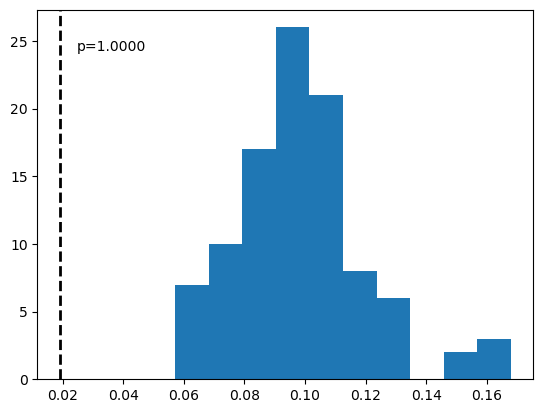

In [106]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(spike_info, surrs, verbose=True,plot = True)

### ANOVA 

In [107]:
# Compute spatial information measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    trial_place_bins = compute_trial_place_bins(stimes, filt_positions, filt_ptimes, move_bins, move_start, move_end,
                                         
                                            trial_occupancy=move_trial_occupancy,time_threshold = .1, flatten=True)
    
    surrogates[ind] = fit_anova_place(create_df_place(trial_place_bins))

p-value: 1.00
z-score: -3.95


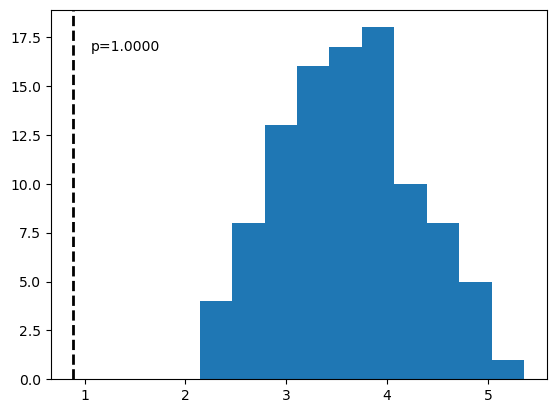

In [108]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(move_f_val, surrogates, verbose=True,plot = True)

p-value: 1.00
z-score: -3.61
p-value: 1.00
z-score: -3.95


Text(0.5, 1.0, 'ANOVA f-val:0.887')

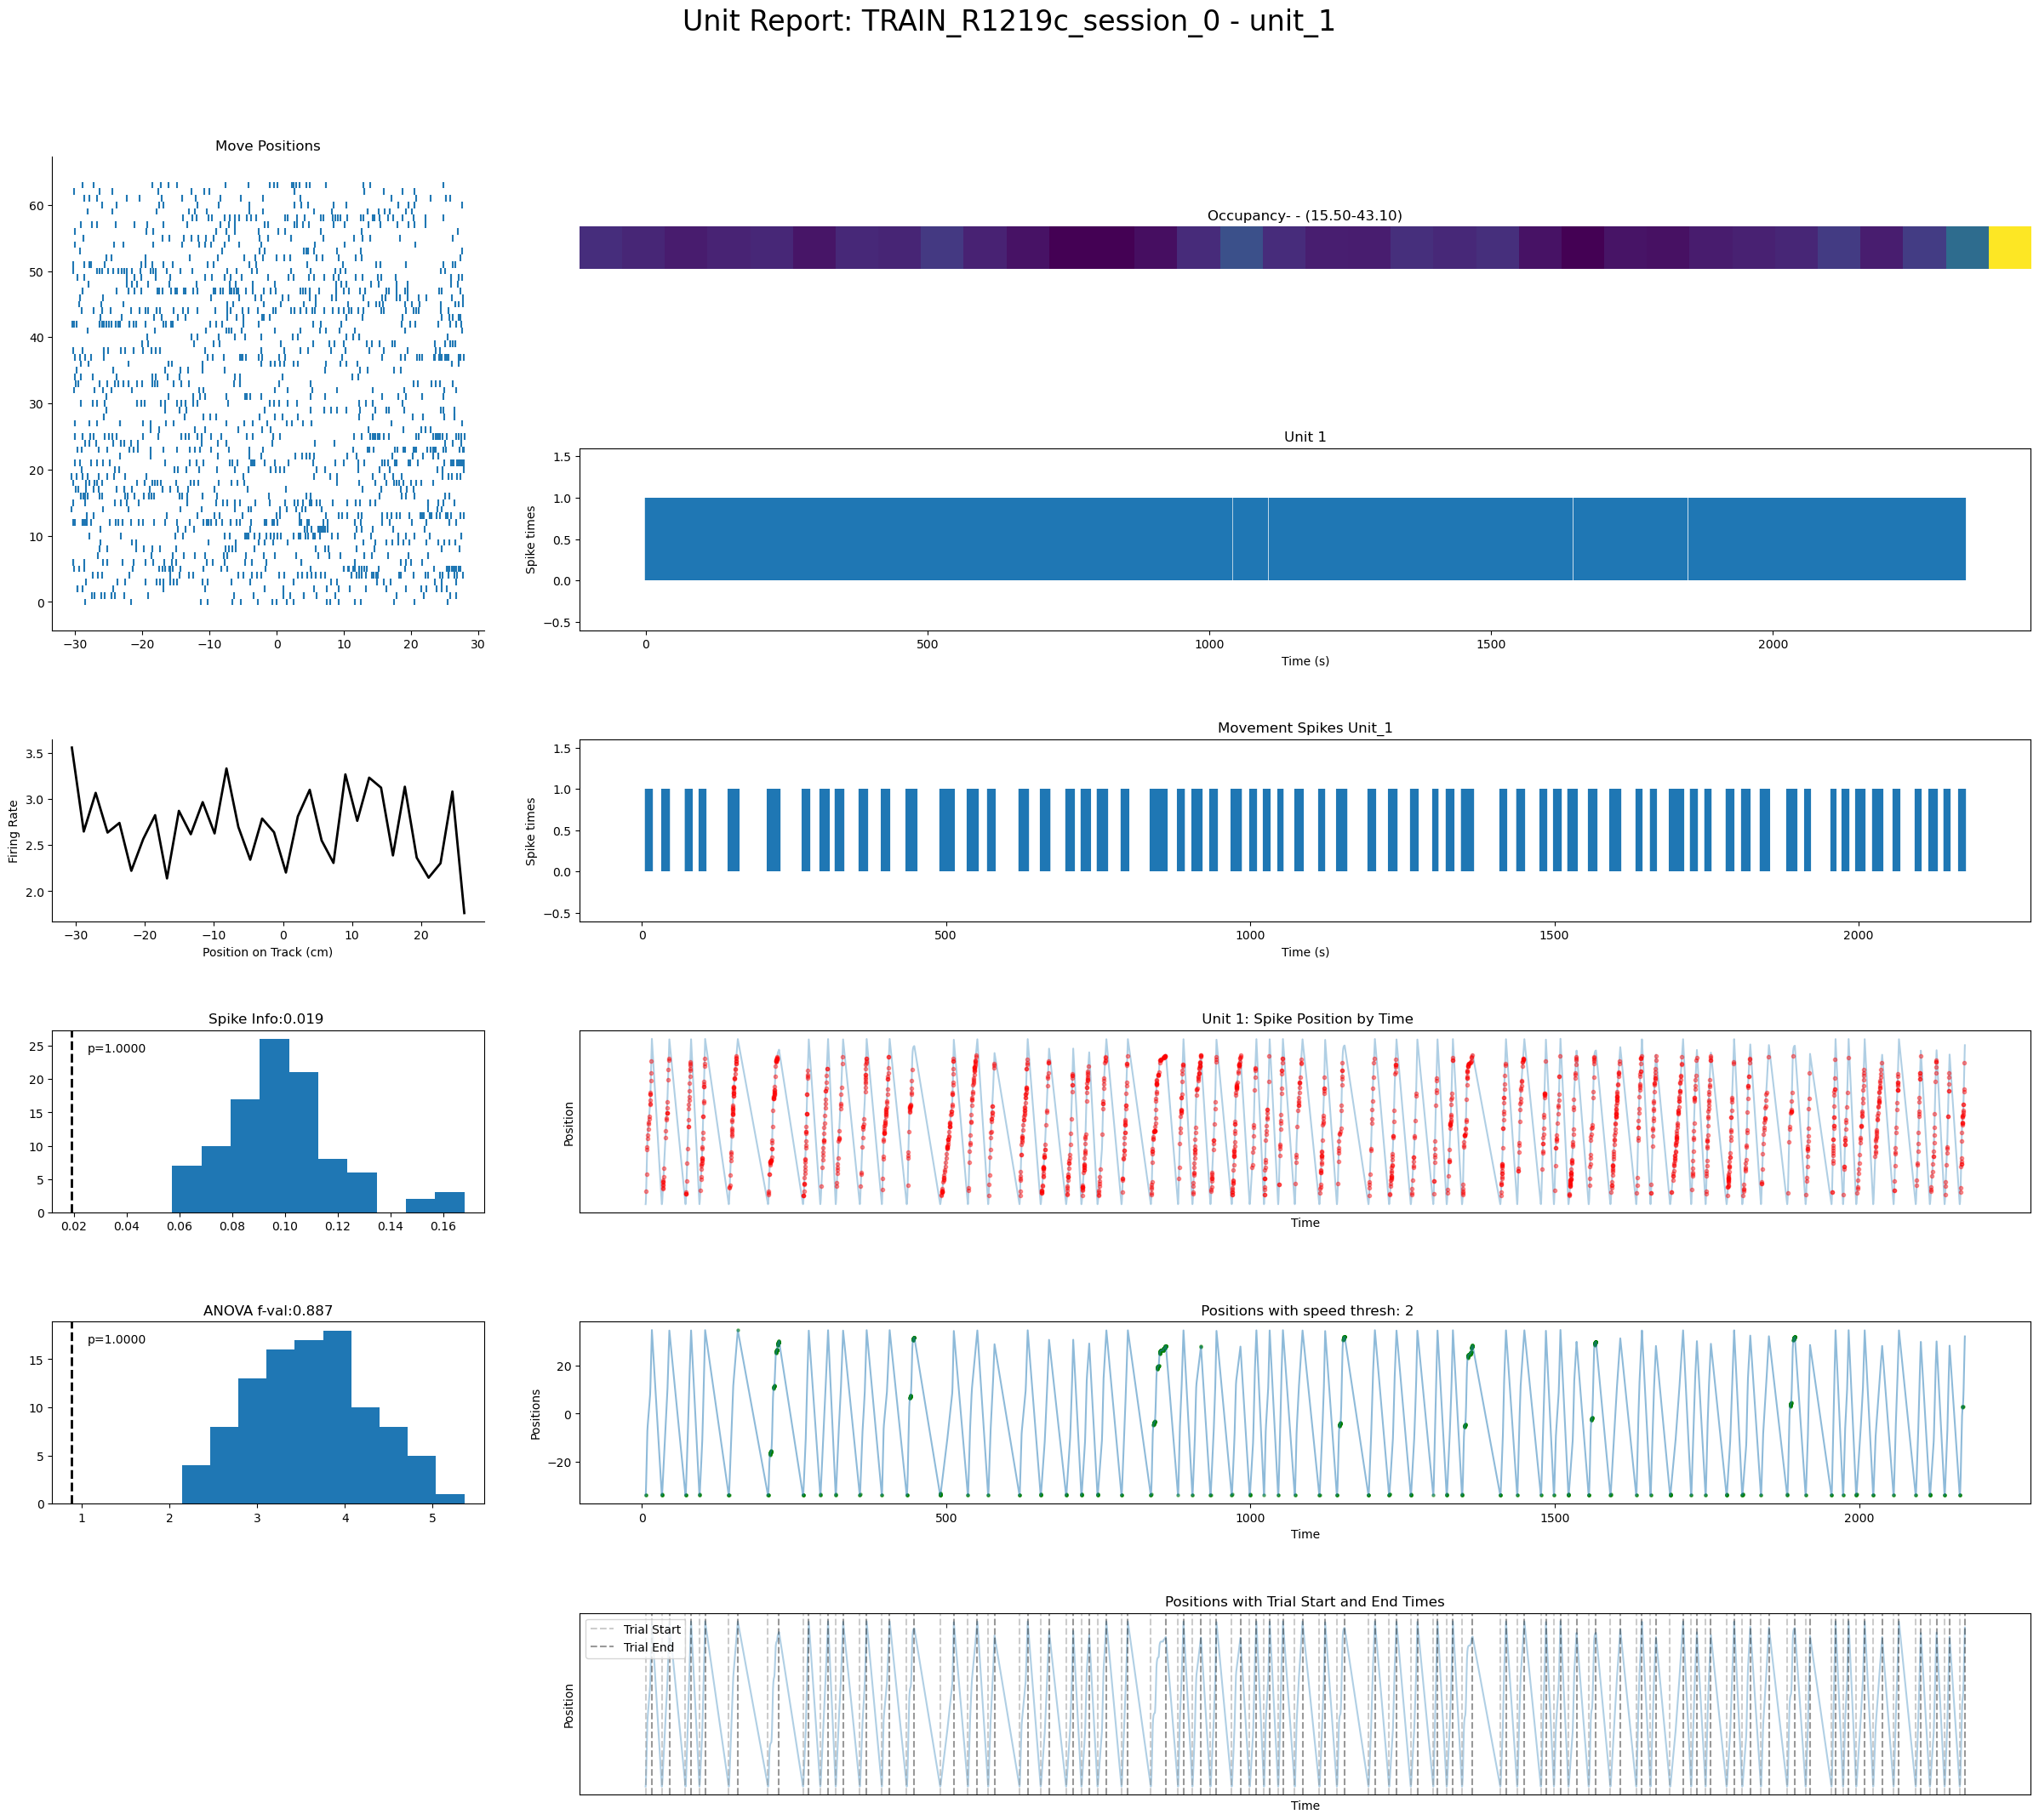

In [114]:
# Initialize figure with grid layout
grid = make_grid(6, 5, wspace=0.3, hspace=.6, figsize=(30, 25),
                 width_ratios=[.4,.4, 1, 1, 1],
                 title=f'Unit Report: {session_name} - unit_{uind}')

plot_heatmap(move_occ, title=create_heatmap_title('Occupancy-',move_occ), ax = get_grid_subplot(grid, slice(0, 1), slice(2, 5)))

ax = get_grid_subplot(grid, slice(1, 2), slice(2, 5))
ax.eventplot(spikes, lineoffsets=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike times')
ax.set_title(f'Unit {uind}')

ax = get_grid_subplot(grid, slice(2, 3), slice(2, 5))
ax.eventplot(move_spikes_all, lineoffsets=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike times')
ax.set_title(f'Movement Spikes Unit_{uind}')

plot_position_by_time(ptimes,positions,spike_times_all,filt_spike_pos_all , ax = get_grid_subplot(grid, slice(3, 4), slice(2, 5)))
plt.title(f' Unit {uind}: Spike Position by Time')

plot_positions_with_speed(ptimes, positions, speed,speed_thresh,ax = get_grid_subplot(grid, slice(4, 5), slice(2, 5)))
plt.title(f' Positions with speed thresh: {speed_thresh}')


plot_position_by_time(ptimes, positions, ax=get_grid_subplot(grid, slice(5,6), slice(2, 5)))
for start in trial_start:
    plt.axvline(x=start, color='grey', alpha=0.4, linestyle='--', label='Trial Start' if start == trial_start[0] else "")
for end in trial_end:
    plt.axvline(x=end, color='black', alpha=0.4, linestyle='--', label='Trial End' if end == trial_end[0] else "")
plt.title('Positions with Trial Start and End Times')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()


plot_rasters(filt_spike_pos,ax=get_grid_subplot(grid,  slice(0,2), slice(0,2)), vline=None, show_axis=True, title='Move Positions')
drop_spines(['top', 'right'],ax=get_grid_subplot(grid,  slice(0,2), slice(0,2)))


ax = get_grid_subplot(grid, 2,slice(0,2))
ax.plot( m_bins[:-1],move_fr[:], 'k', lw=2)
ax.set_xlabel('Position on Track (cm)')
ax.set_ylabel('Firing Rate')
ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)

# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(spike_info, surrs, verbose=True,plot = True, ax =get_grid_subplot(grid,  3, slice(0,2)))
plt.title(f'Spike Info:{np.round(spike_info,3)} ')
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(move_f_val, surrogates, verbose=True,plot = True, ax =get_grid_subplot(grid,  4, slice(0,2)))
plt.title(f'ANOVA f-val:{np.round(move_f_val,3)}')
